#### Note: This will run if you have the the movies saved as "start_numor".npz files. Check other notebook titled SANS_to_npz.ipynb for code to assist in doing this.

In [97]:
"""
to run the notebook, first replace all file paths (check for `np.load` and `file_path`).
search for `gif = movies[i]` where this line allows you to change the set of data
Parameters to tune: `FILTER_SIGNAL_THRESHOLD`, `laser_threshold`, `angle_above_offset` (in fix snapback section where you can decide if you want to change offsets)
"""

'\nto run the notebook, first replace all file paths (check for `np.load` and `file_path`).\nsearch for `gif = movies[i]` where this line allows you to change the set of data\nParameters to tune: `FILTER_SIGNAL_THRESHOLD`, `laser_threshold`, `angle_above_offset` (in fix snapback section where you can decide if you want to change offsets)\n'

# Powell optimizer (2 filters)

#### functions

In [98]:
import numpy as np
from PIL import Image, ImageSequence
import matplotlib.pyplot as plt
import torch

In [99]:
# Global parameters (don't change)
MS = torch.arange(12)
ANGLES = torch.arange(0, 6) * 2 * torch.pi / 6.

# Extract data_theta, doesn't matter what images is extracted since we're just getting theta
# DATA = np.load(r"C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Angle reference file (random file from Caden)\image_111010.npz")['data']
DATA = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/npz_temp_sweep/image_theta.npz')['data']
DATA_THETA = torch.atan2(torch.tensor(DATA[1]), torch.tensor(DATA[0]))

In [100]:
def normalize_min_max(data):
    if isinstance(data, torch.Tensor):
        array = data.numpy()
    else:
        array = data

    array_min = np.min(array)
    array_max = np.max(array)
    norm_array = (array - array_min) / (array_max - array_min)

    if isinstance(data, torch.Tensor):
        norm_tensor = torch.tensor(norm_array)
        return norm_tensor
    else:
        return norm_array

In [102]:
# Create masks
def apply_threshold_to_sin(filter, threshold=.5):
    """Given threshold value between 0 and 1, this function sets all values below threshold to 0 and 
    everything above threshold to 1. Input images are first normalized between 0 and 1. 
    So typically threshold is between 0 and 1. 
    ** Higher threshold means thinner lasers. **
    When `threshold = -1` (default value) this function doesn't change anything.
    """
    mask = torch.ones_like(filter, dtype=torch.float32)
    filter = normalize_min_max(filter)
    mask[filter < threshold] = 0
    mask[filter >= threshold] = 1
    mask_with_applied_threshold = mask
    return mask_with_applied_threshold


def create_mask_from_intensity(intensity, evaluate_image):
    """Mask regions in `evaluate_image` where the values are positive, setting these regions in `intensity` to 0.
    This allows for a masked intensity image to be used in multiple filterings."""
    mask = torch.ones_like(evaluate_image, dtype=torch.float32)
    mask[evaluate_image > 0] = 0
    masked_intensity = intensity * mask
    return masked_intensity

### VISUALIZE EFFECTS OF apply_threshold_to_sin() FUNCTION ###
# projection = project_theta(ANGLES, MS).sum(1)
# evaluate_image_theta = evaluate_functions_on_theta(DATA_THETA, projection, MS)
# mask = apply_threshold_to_sin(evaluate_image_theta)
# plt.imshow(mask)

### MISC STUFF ###
# projection = project_theta(ANGLES, MS).sum(1)
# evaluate_image_theta = evaluate_functions_on_theta(DATA_THETA, projection, MS)
# step_func_mask = apply_threshold_to_sin(evaluate_image_theta)
# plt.imshow(step_func_mask)
# plt.show()
# masked_image = create_mask_from_intensity(intensity_data[0], step_func_mask)
# plt.imshow(masked_image)
# plt.show()
# plt.imshow(intensity_data[0])


In [103]:
# Global parameters for model (usually we don't need to change this)
# MAX_ITER_OFFSET = 101
# LR = 1e-2
OFFSET_ADJUSTMENT = np.deg2rad(60)
FILTER_SIGNAL_THRESHOLD = 0.4

In [104]:
from scipy.optimize import minimize
k = 1

def optimize_single_offset(intensity, offset, laser_threshold=-1):
    initial_offset = offset
    bounds=[(np.deg2rad(initial_offset-25), np.deg2rad(initial_offset+25))]

    def objective_function(offset):
        evaluate_image_theta = torch.exp( k * torch.log( (torch.sin(3 * (DATA_THETA + offset)))**2 ) )
        evaluate_image_theta = apply_threshold_to_sin(evaluate_image_theta, threshold=laser_threshold)
        loss = -(intensity * evaluate_image_theta).sum()
        return loss.item()

    result = minimize(objective_function, [initial_offset], method='Powell', bounds=bounds)
    optimal_offset = result.x[0]

    final_projection = project_theta(ANGLES + optimal_offset, MS).sum(1)
    final_evaluate_image_theta = evaluate_functions_on_theta(DATA_THETA, final_projection, MS)
    final_evaluate_image_theta = apply_threshold_to_sin(final_evaluate_image_theta, threshold=laser_threshold)

    return optimal_offset, final_evaluate_image_theta


In [105]:
# 2 filters
def optimize_offset_2filters(intensity, offset1, offset2, laser_threshold=-1):
    """
    Determine the additional laser as follows:
    1. mask intensity: mask out the intensity data of the previous laser.
    2. check for signals: if no strong signal remains, assume no additional peaks.
       apply a filter to the original intensity to detect the same laser with potentially different offset angles.
    3. otherwise apply filter to masked intensity.
    """
    print("Optimizing offset 1...")
    offset1, evaluate_image_theta1 = optimize_single_offset(intensity, offset1, laser_threshold=laser_threshold)
    masked_intensity = create_mask_from_intensity(intensity, evaluate_image_theta1)
    if masked_intensity.max() <= FILTER_SIGNAL_THRESHOLD * intensity.max():
        masked_intensity = intensity
    
    print('Optimizing offset 2...')
    offset2, evaluate_image_theta2 = optimize_single_offset(masked_intensity, offset2, laser_threshold=laser_threshold)
    
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
    im0 = ax[0].imshow(((evaluate_image_theta1 / evaluate_image_theta1.abs().max() + intensity / intensity.abs().max()).detach()).T, origin='lower')
    ax[0].set_title('GD 1')
    # fig.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(((evaluate_image_theta2 / evaluate_image_theta2.abs().max() + intensity / intensity.abs().max()).detach()).T, origin='lower')
    ax[1].set_title('GD 2')
    # fig.colorbar(im1, ax=ax[1])
    
    im2 = ax[2].imshow(intensity.T, origin='lower')
    ax[2].set_title('Signal searched in GD 1')
    # fig.colorbar(im2, ax=ax[2])

    im3 = ax[3].imshow(masked_intensity.T, origin='lower')
    ax[3].set_title('Signal searched in GD 2')
   #  fig.colorbar(im3, ax=ax[3])

    plt.show()

    return np.rad2deg(offset1), np.rad2deg(offset2)

In [106]:
def peak_split_logic(offset1, offset2, offset_diff_threshold=1):
    '''Determines if there is peak splitting based off input threshold value'''
    offset_diff_threshold = np.deg2rad(offset_diff_threshold)
    offset2_valid = True
    if np.abs(offset1 - offset2) <= offset_diff_threshold:
        offset2_valid = False

    offset2_val = np.nan if not offset2_valid else offset2
    return offset2_val

In [107]:
# INCORPORATING LOGIC

def optimize_offset_2filters(intensity, offset1, offset2, laser_threshold=-1):
    """
    Determine the additional laser as follows:
    1. mask intensity: mask out the intensity data of the previous laser.
    2. check for signals: if no strong signal remains, assume no additional peaks.
       apply a filter to the original intensity to detect the same laser with potentially different offset angles.
    3. otherwise apply filter to masked intensity.
    """
    print("Optimizing offset 1...")
    offset1, evaluate_image_theta1 = optimize_single_offset(intensity, offset1, laser_threshold=laser_threshold)
    masked_intensity = create_mask_from_intensity(intensity, evaluate_image_theta1)
    if masked_intensity.max() <= FILTER_SIGNAL_THRESHOLD * intensity.max():
        masked_intensity = intensity
    
    print('Optimizing offset 2...')
    offset2, evaluate_image_theta2 = optimize_single_offset(masked_intensity, offset2, laser_threshold=laser_threshold)
    
    # offset2 = peak_split_logic(offset1, offset2)

    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15, 5))
    im0 = ax[0].imshow(((evaluate_image_theta1 / evaluate_image_theta1.abs().max() + intensity / intensity.abs().max()).detach()).T, origin='lower')
    ax[0].set_title('Powell 1')
    # fig.colorbar(im0, ax=ax[0])

    im1 = ax[1].imshow(((evaluate_image_theta2 / evaluate_image_theta2.abs().max() + intensity / intensity.abs().max()).detach()).T, origin='lower')
    ax[1].set_title('Powell 2')
    # fig.colorbar(im1, ax=ax[1])
    
    im2 = ax[2].imshow(intensity.T, origin='lower')
    ax[2].set_title('Signal searched in Powell 1')
    # fig.colorbar(im2, ax=ax[2])

    im3 = ax[3].imshow(masked_intensity.T, origin='lower')
    ax[3].set_title('Signal searched in Powell 2')
   #  fig.colorbar(im3, ax=ax[3])

    plt.show()

    return np.rad2deg(offset1), np.rad2deg(offset2)

In [108]:
# Helper function to fix snapback
def adjust_offset_within_bounds(offset_list, angle_above_offset=50):
    angle_above_offset = np.deg2rad(angle_above_offset)
    angle_below_offset = np.deg2rad(60) - angle_above_offset
    adjusted_offsets = []
    prev_offset = offset_list[0]
    for index, offset in enumerate(offset_list):
        if index == 0:
            adjusted_offsets.append(offset)
            prev_offset = offset
        else:
            offset_range = (prev_offset - angle_below_offset, prev_offset + angle_above_offset)
            while not (offset_range[0] <= offset <= offset_range[1]):
                offset += OFFSET_ADJUSTMENT if offset < offset_range[0] else -OFFSET_ADJUSTMENT
            adjusted_offsets.append(offset)
            prev_offset = offset
    return adjusted_offsets

#### Apply functions to real data

In [109]:
# Import images from .npz files
# Extract data file paths
# file_path = r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\HDF to npz files\\'
file_path = "/Users/cadenmyers/billingelab/dev/skyrmion_lattices/experimental_data/"

# FIELD SWEEP MOVIES
filenames = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz', 'Field_37mT.npz']
movies = ['npz_field_sweep_old/' + filename for filename in filenames]

# TEMP SWEEP MOVIES
# filenames = ['121855.npz', '118923.npz', '119486.npz', '119996.npz', '120506.npz', '121016.npz', '121405.npz', '121550.npz', '122365.npz', '122875.npz']
# movies = ['npz_temp_sweep/' + filename for filename in filenames]

# Define the movie you want to run GD and GS on as gif (gif = movies[i])
gif = movies[0]
print(gif)
movie = np.load(file_path + gif)
intensity_data = torch.tensor(movie['data'])
print(intensity_data.shape)


npz_field_sweep_old/Field_29mT.npz
torch.Size([20, 128, 128])


Optimizing offset 1...
Optimizing offset 2...


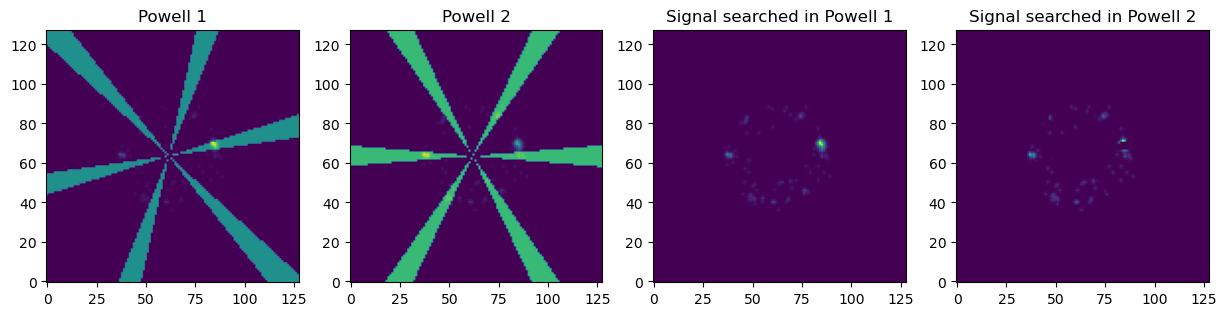

10s: offset 1 = 12.86553851832951
10s: offset 2 = -0.10883887676676043
Optimizing offset 1...
Optimizing offset 2...


/var/folders/2v/z3xfrmpn6dbcyt913rndt0jr0000gn/T/ipykernel_45374/998121373.py:14: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(objective_function, [initial_offset], method='Powell', bounds=bounds)


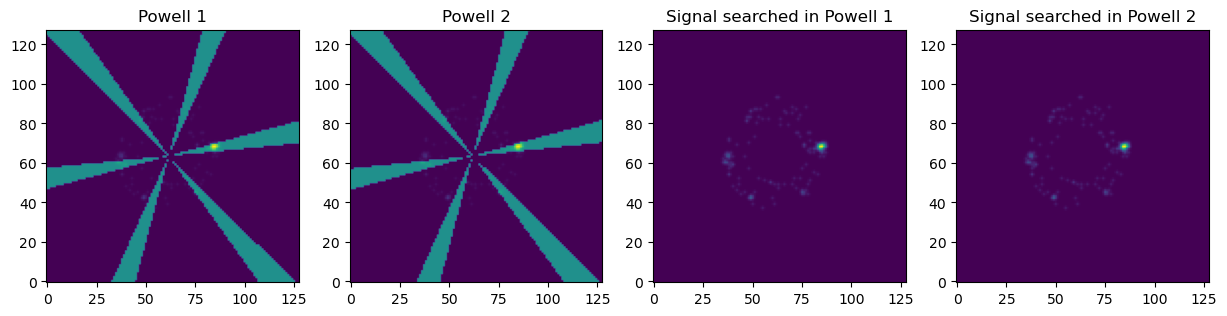

20s: offset 1 = 10.326418339064311
20s: offset 2 = 10.684965414127609
Optimizing offset 1...
Optimizing offset 2...


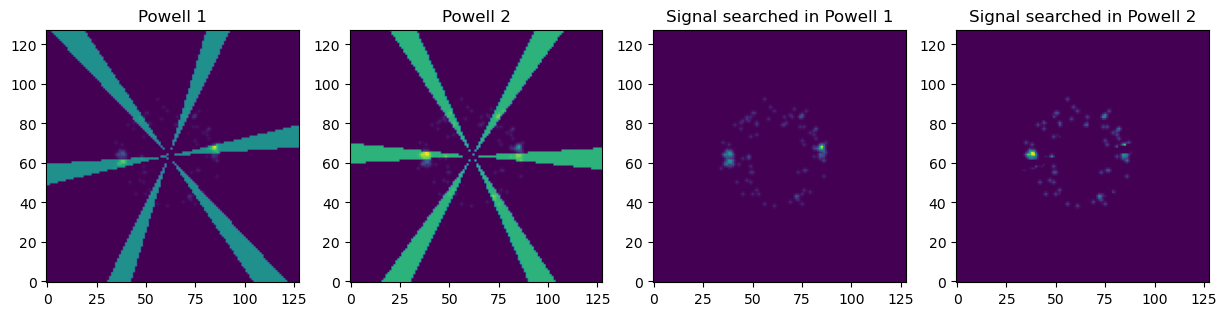

30s: offset 1 = 8.586566164424081
30s: offset 2 = -1.2327714557244562
Optimizing offset 1...
Optimizing offset 2...


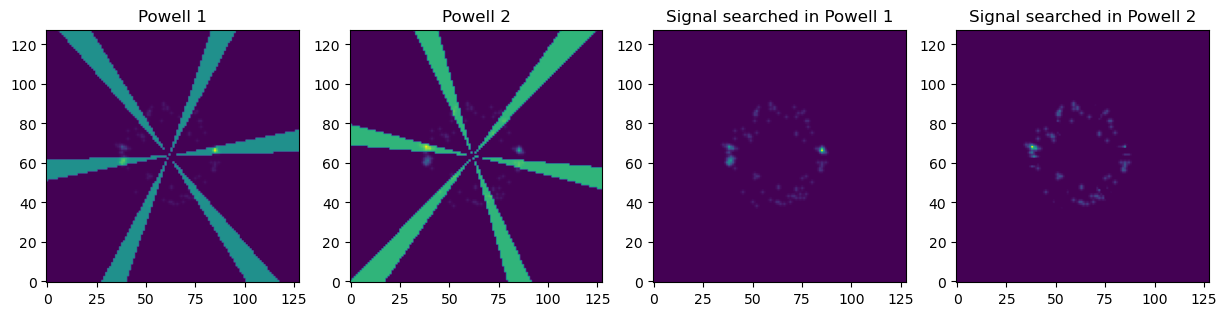

40s: offset 1 = 6.5800845783618085
40s: offset 2 = -9.769122353855543
Optimizing offset 1...
Optimizing offset 2...


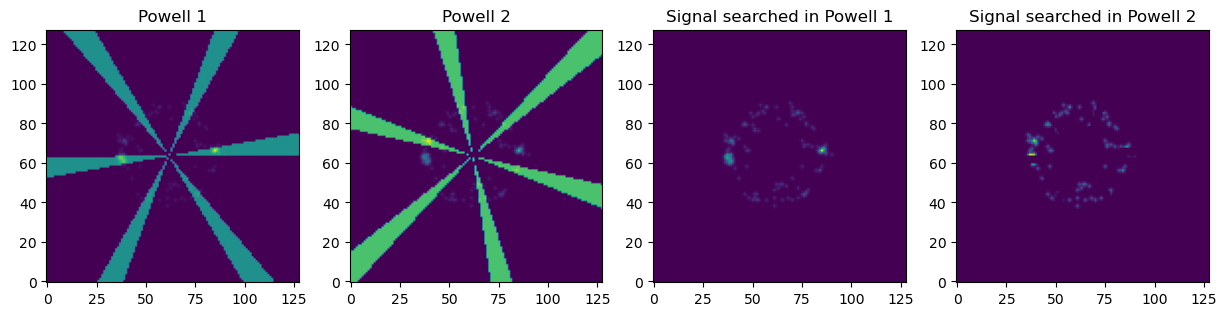

50s: offset 1 = 5.3374097273986845
50s: offset 2 = -17.229373963161393
Optimizing offset 1...
Optimizing offset 2...


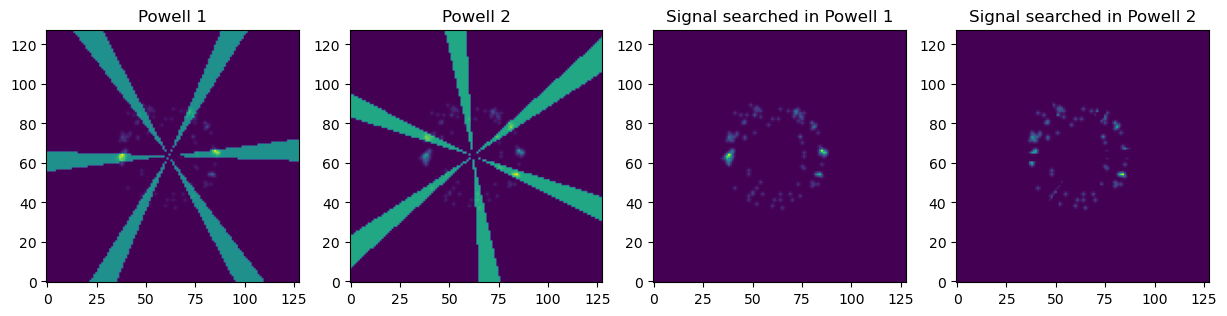

60s: offset 1 = 2.588814176259831
60s: offset 2 = -22.253510865825454
Optimizing offset 1...
Optimizing offset 2...


KeyboardInterrupt: 

In [115]:
# Hyperparameters to tune
laser_threshold = 0.94
# you can also change angle_above_offset in the next chunk

# GD training data
td_offset = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/analysis-generated_data/gradient_offset_data/gradient_decent_121855.npz')['offset']
td_time = np.load('/Users/cadenmyers/billingelab/dev/skyrmion_lattices/analysis-generated_data/gradient_offset_data/gradient_decent_121855.npz')['time']

# Loop through the movie
offset_list1, offset_list2 = [], []
offset1 = 0#torch.tensor(0., requires_grad=True)
offset2 = 0#torch.tensor(0., requires_grad=True)
for index, image in enumerate(intensity_data):
    offset1, offset2 = optimize_offset_2filters(image, offset1, offset2, laser_threshold=laser_threshold)

    print(f'{(index + 1) * 10}s: offset 1 = {offset1}')
    offset_list1.append(offset1)
    print(f'{(index + 1) * 10}s: offset 2 = {offset2}')
    offset_list2.append(offset2)

# Plot offset angles
time = np.array(range(len(offset_list1))) * 10 + 10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(time, offset_list1, label="offset1")
# ax[0].plot(td_time, td_offset, label="td_offset", linestyle='--')
ax[0].set_ylabel('Offset angle')
ax[0].set_xlabel("Time (s)")
ax[1].plot(time, offset_list2, label="offset2")
ax[1].set_ylabel('Offset angle')
ax[1].set_xlabel("Time (s)")
ax[0].legend()
ax[1].legend()
plt.show()

print(offset_list1)
print(offset_list2)

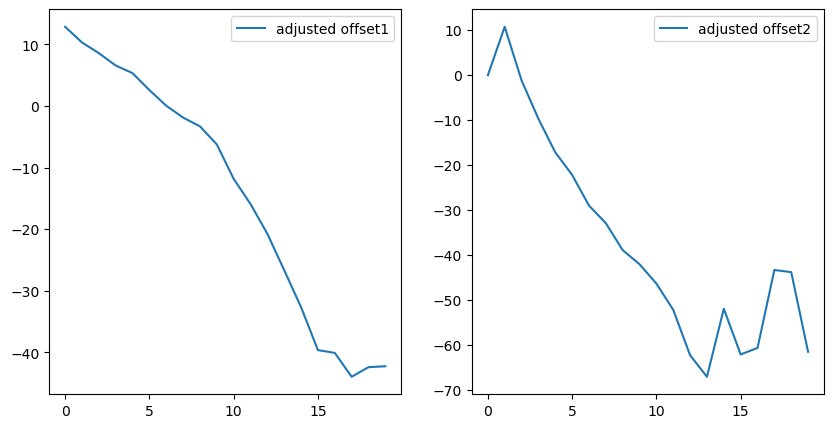

FileNotFoundError: [Errno 2] No such file or directory: '/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/npz_field_sweep_old/Field_29mT.npz'

In [111]:
# If you want to fix snapback
adjusted_offset_list1 = offset_list1#adjust_offset_within_bounds(offset_list1, angle_above_offset=10)
adjusted_offset_list2 = offset_list2#adjust_offset_within_bounds(offset_list2, angle_above_offset=20)

# Plot offset angles
time = np.array(range(len(offset_list1))) * 10 + 10
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
ax[0].plot(adjusted_offset_list1, label="adjusted offset1")
ax[1].plot(adjusted_offset_list2, label="adjusted offset2")
ax[0].legend()
ax[1].legend()
plt.show()

# Save model data
adjusted_offset_list1=np.array(adjusted_offset_list1)
adjusted_offset_list2=np.array(adjusted_offset_list2)
# file_path = r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Peak Tracking npz files\\'
file_path = rf'/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/'
full_path = file_path + gif
np.savez(full_path, gif, offset1=adjusted_offset_list1, offset2=adjusted_offset_list2, time=time)



# Angular velocity calculation

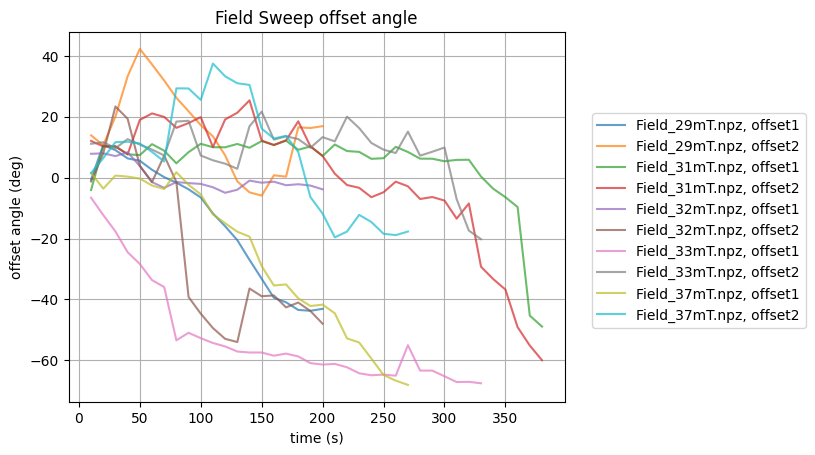

In [ ]:
movies = ['Field_29mT.npz', 'Field_31mT.npz', 'Field_32mT.npz', 'Field_33mT.npz','Field_37mT.npz']

for gif in movies:
    # ratchet_model_data = np.load(rf'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Peak Tracking npz files\{gif}')
    ratchet_model_data = np.load(rf'/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/{gif}')
    rm_time = ratchet_model_data['time']
    rm_offset1 = ratchet_model_data['offset1']
    rm_offset2 = ratchet_model_data['offset2']
    plt.plot(rm_time, rm_offset1, label=f'{gif}, offset1', alpha=.7)
    plt.plot(rm_time, rm_offset2, label=f'{gif}, offset2', alpha=.7)

plt.xlabel('time (s)')
# plt.xlim(0, 380)
plt.ylabel('offset angle (deg)')
plt.grid(True)
plt.legend(loc='upper right', bbox_to_anchor=(1.5, 0.8))
plt.title('Field Sweep offset angle')
# plt.tight_layout()
# plt.savefig(r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Exported Figures\FieldSweepPositions.png')
plt.show()


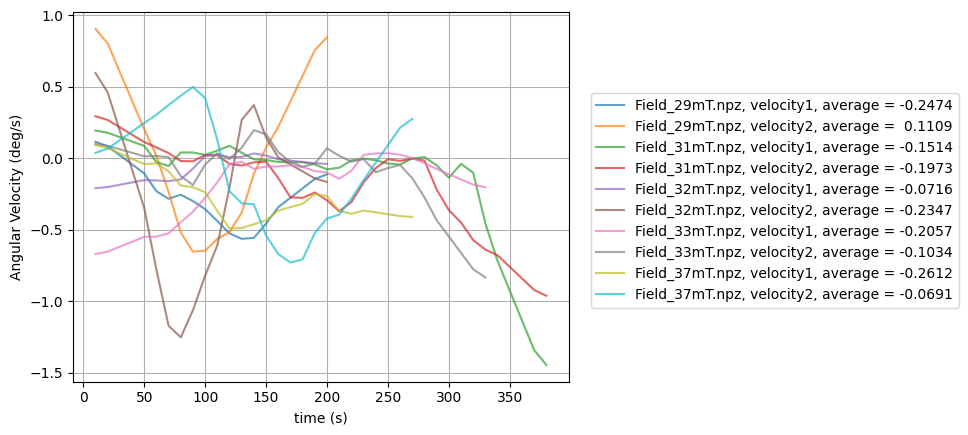

In [ ]:
from scipy.signal import savgol_filter
def compute_smoothed_derivative(time, offset, window_length=11, polyorder=2):
    '''compute velocity of data after savgol_filter is applied'''
    smoothed_angle = savgol_filter(offset, window_length=window_length, polyorder=polyorder)
    time = np.array(time)
    smoothed_derivative = (np.gradient(smoothed_angle, time))
    return smoothed_derivative

# calculate angular velo and plot
for gif in movies:
    # ratchet_model_data = np.load(rf'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Peak Tracking npz files\{gif}')
    ratchet_model_data = np.load(rf'/Users/yucongchen/billingegroup/skyrmion_lattices/skyrmion-lattices-data/Field_Sweep_data/angles/{gif}')
    rm_time = ratchet_model_data['time']
    rm_offset1 = ratchet_model_data['offset1']
    rm_offset2 = ratchet_model_data['offset2']
    velo1 = compute_smoothed_derivative(rm_time, rm_offset1)
    velo2 = compute_smoothed_derivative(rm_time, rm_offset2)
    plt.plot(rm_time, velo1, label=f'{gif}, velocity1, average = {np.mean(velo1): .04f}', alpha=.7)
    plt.plot(rm_time, velo2, label=f'{gif}, velocity2, average = {np.mean(velo2): .04f}', alpha=.7)

plt.xlabel('time (s)')
# plt.xlim(0,380)
plt.ylabel('Angular Velocity (deg/s)')
plt.legend(loc='upper right', bbox_to_anchor=(1.8, 0.8))
# plt.title('Ratchet Model')
plt.grid(True)
# plt.savefig(r'C:\Users\Nathan\OneDrive - nd.edu\Desktop\SANS Data\Experiments\PSI Cu2OSeO3 Corbino July 2023\Analysis\Field Sweep\Exported Figures\FieldSweepVelocities.png')
plt.show()